In [ ]:
import concurrent.futures
import os
import pickle
import face_recognition

ENCODING_FILE = "encodings_hog/encodings.pkl"
KNOWN_DIR = "known_faces/dataset_imgs"


def encode_image(file):
    try:
        path = os.path.join(KNOWN_DIR, file)
        print(f"📸 Loading image: {path}")

        # load the image as RGB array
        img = face_recognition.load_image_file(path)

        # Extract face encodings
        enc = face_recognition.face_encodings(img)

        print(f"🔍 Faces found in {file}: {len(enc)}")

        # Accept only single-face images
        if len(enc) == 1:
            print(f"✅ Encoded: {file}")
            return enc[0], os.path.splitext(file)[0]
        else:
            print(f"⚠️ Skipped (not exactly 1 face): {file}")
            return None

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")
        return None


def load_known_faces():
    known_faces, known_names = [], []

    # Load existing encodings if available
    if os.path.exists(ENCODING_FILE):
        print("📦 Loading existing encodings from PKL...")
        with open(ENCODING_FILE, "rb") as f:
            known_faces, known_names = pickle.load(f)

        print(f"✅ Loaded {len(known_faces)} known faces from file")

    existing = set(known_names)

    # Load dataset images
    files = [f for f in os.listdir(KNOWN_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]
    print(f"🖼️ Found {len(files)} images in dataset folder")

    new_count = 0
    skip_count = 0

    for file in files:
        name = os.path.splitext(file)[0]

        # Skip already encoded users
        if name in existing:
            print(f"⏭️ Already exists, skipping: {file}")
            skip_count += 1
            continue

        res = encode_image(file)
        if res:
            known_faces.append(res[0])
            known_names.append(res[1])
            new_count += 1

    # Save updated encodings
    print("💾 Saving encodings to PKL file...")
    with open(ENCODING_FILE, "wb") as f:
        pickle.dump((known_faces, known_names), f)

    print("\n================ SUMMARY ================")
    print(f"➕ New faces added: {new_count}")
    print(f"⏭️ Skipped existing: {skip_count}")
    print(f"📊 Total stored faces: {len(known_faces)}")
    print("========================================\n")

    return known_faces, known_names


📦 Loading existing encodings from PKL...
✅ Loaded 402 known faces from file
🖼️ Found 413 images in dataset folder
⏭️ Already exists, skipping: 100_10.jpg
⏭️ Already exists, skipping: 101_11.jpg
⏭️ Already exists, skipping: 102_11.jpg
⏭️ Already exists, skipping: 103_11.jpg
⏭️ Already exists, skipping: 104_11.jpg
⏭️ Already exists, skipping: 105_11.jpg
⏭️ Already exists, skipping: 106_11.jpg
⏭️ Already exists, skipping: 107_11.jpg
⏭️ Already exists, skipping: 108_11.jpg
⏭️ Already exists, skipping: 109_11.jpg
⏭️ Already exists, skipping: 10_1.jpg
⏭️ Already exists, skipping: 110_11.jpg
⏭️ Already exists, skipping: 111_12.jpg
⏭️ Already exists, skipping: 112_12.jpg
⏭️ Already exists, skipping: 113_12.jpg
⏭️ Already exists, skipping: 114_12.jpg
⏭️ Already exists, skipping: 115_12.jpg
⏭️ Already exists, skipping: 116_12.jpg
⏭️ Already exists, skipping: 117_12.jpg
⏭️ Already exists, skipping: 118_12.jpg
⏭️ Already exists, skipping: 119_12.jpg
⏭️ Already exists, skipping: 11_2.jpg
⏭️ Already

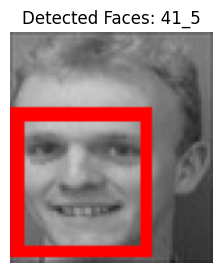

{
  "status": "matched",
  "person": "41_5",
  "confidence": 1.0,
  "time_taken_sec": 0.956
}


In [42]:
import cv2
import sys
import numpy as np
import json
import time
import matplotlib.pyplot as plt

def recognize_face(input_image_file):
    start_time = time.time()

    known_faces, known_names = load_known_faces()
    if not known_faces:
        return {"status": "no_known_faces"}

    # Load input image as RGB
    input_image = face_recognition.load_image_file(input_image_file)

    # Step 1: Detect faces
    face_locations = face_recognition.face_locations(input_image, model="hog")
    if not face_locations:
        return {"status": "no_face_detected"}

    # Step 2: Encode detected faces
    input_encodings = face_recognition.face_encodings(input_image, known_face_locations=face_locations)
    if not input_encodings:
        return {"status": "encoding_failed"}

    # Step 3: Compare with known faces
    matched_person = None
    matched_confidence = None
    for input_encoding in input_encodings:
        known_faces_np = np.array(known_faces)
        distances = np.linalg.norm(known_faces_np - input_encoding, axis=1)

        best_match_index = distances.argmin()
        best_distance = distances[best_match_index]

        if best_distance < 0.50:
            matched_person = known_names[best_match_index]
            matched_confidence = round(1 - best_distance, 3)
            # matched_confidence = max(0, (0.6 - best_distance) / 0.6)
            break

    display_image = input_image.copy()

    for (top, right, bottom, left) in face_locations:
        display_image[top:bottom, left:right] = cv2.rectangle(
            display_image[top:bottom, left:right].copy(),
            (0,0), (right-left, bottom-top),
            (255,0,0), 8
        )

    plt.figure(figsize=(3,3))
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Detected Faces: {matched_person if matched_person else 'Unknown'}")
    plt.show()

    if matched_person:
        return {
            "status": "matched",
            "person": matched_person,
            "confidence": matched_confidence,
            "time_taken_sec": round(time.time() - start_time, 3)
        }

    return {
        "status": "not_matched",
        "time_taken_sec": round(time.time() - start_time, 3)
    }


if __name__ == "__main__":
    if len(sys.argv) > 1:
        image_path = sys.argv[1]
        result = recognize_face("new_img.jpg")
        print(json.dumps(result, indent=2))
    else:
        print("Usage: python script.py <image_path>")